<a href="https://colab.research.google.com/github/shinji19620524/my-first-blog/blob/master/%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF_%E3%83%99%E3%82%B9%E3%83%88%E3%82%B9%E3%82%B3%E3%82%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前回勉強会では、勾配ブースティングで生存率を予測し、SIGNATEの評価が「0.8784929」（46位）となりました。

今回は、この評価の更新を目指します。

In [ ]:
# matplotlibの日本語対応ライブラリをインストール
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=1b96ba2ab99fd54b3e352ca7168cfc9611b68d9ceed73fd943aee2dd255b831d
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


**1. データを読み込もう**

In [ ]:
# アップロードしたデータをデータフレームに変換
import pandas as pd
train = pd.read_csv("train.tsv", sep="\t", index_col=0)                               # 学習用データ
test = pd.read_csv("test.tsv", sep="\t", index_col=0)                                 # 評価用データ
sample_submit = pd.read_csv("sample_submit.tsv", sep="\t", index_col=0, header=None)  # 応募用サンプルファイル

**2. データの概要を確認しよう**

In [ ]:
# 学習用データ、評価用データの先頭5件を確認
print(train.head())
print('====================================================================')
print(test.head())

    survived  pclass     sex   age  sibsp  parch     fare embarked
id                                                                
3          1       1  female  35.0      1      0  53.1000        S
4          0       3    male  35.0      0      0   8.0500        S
7          0       3    male   2.0      3      1  21.0750        S
9          1       2  female  14.0      1      0  30.0708        C
11         1       1  female  58.0      0      0  26.5500        S
    pclass     sex   age  sibsp  parch     fare embarked
id                                                      
0        3    male  22.0      1      0   7.2500        S
1        1  female  38.0      1      0  71.2833        C
2        3  female  26.0      0      0   7.9250        S
5        3    male   NaN      0      0   8.4583        Q
6        1    male  54.0      0      0  51.8625        S


In [ ]:
# 学習用データと評価用データのサイズ（行数、列数）を確認
train.shape, test.shape

((445, 8), (446, 7))

In [ ]:
# 学習用データと評価用データの要約情報（データ型、欠損値有無 等）を確認
print(train.info())
print('====================================================================')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 3 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  445 non-null    int64  
 1   pclass    445 non-null    int64  
 2   sex       445 non-null    object 
 3   age       360 non-null    float64
 4   sibsp     445 non-null    int64  
 5   parch     445 non-null    int64  
 6   fare      445 non-null    float64
 7   embarked  443 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 31.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    446 non-null    int64  
 1   sex       446 non-null    object 
 2   age       354 non-null    float64
 3   sibsp     446 non-null    int64  
 4   parch     446 non-null    int64  
 5   fare      446 non-null    float64
 6   embarked  446 non

In [ ]:
# 学習用データと評価用データの欠損値の割合を確認
print(train.isnull().sum()/train.count())
print('====================================================================')
print(test.isnull().sum()/test.count())

survived    0.000000
pclass      0.000000
sex         0.000000
age         0.236111
sibsp       0.000000
parch       0.000000
fare        0.000000
embarked    0.004515
dtype: float64
pclass      0.000000
sex         0.000000
age         0.259887
sibsp       0.000000
parch       0.000000
fare        0.000000
embarked    0.000000
dtype: float64


In [ ]:
# 学習用データと評価用データの基本統計量（数値項目）を確認
print(train[['pclass', 'age', 'sibsp', 'parch', 'fare', 'survived']].describe())
print('====================================================================')
print(test.describe())

           pclass         age       sibsp       parch        fare    survived
count  445.000000  360.000000  445.000000  445.000000  445.000000  445.000000
mean     2.296629   29.211583    0.546067    0.431461   33.959971    0.402247
std      0.834024   14.154300    1.195247    0.850489   52.079492    0.490903
min      1.000000    0.670000    0.000000    0.000000    0.000000    0.000000
25%      2.000000   20.000000    0.000000    0.000000    7.925000    0.000000
50%      3.000000   28.000000    0.000000    0.000000   15.000000    0.000000
75%      3.000000   37.250000    1.000000    1.000000   31.387500    1.000000
max      3.000000   80.000000    8.000000    5.000000  512.329200    1.000000
           pclass         age       sibsp       parch        fare
count  446.000000  354.000000  446.000000  446.000000  446.000000
mean     2.320628   30.194915    0.500000    0.331839   30.452381
std      0.838873   14.899140    1.002805    0.756823   47.186192
min      1.000000    0.420000    0

In [ ]:
# 学習用データと評価用データの基本統計量（カテゴリ項目）を確認
category = ['sex', 'embarked']
print(train[category].describe())
print('====================================================================')
print(test[category].describe())

         sex embarked
count    445      443
unique     2        3
top     male        S
freq     289      325
         sex embarked
count    446      446
unique     2        3
top     male        S
freq     288      319


In [ ]:
# survivedと各項目の相関係数を取得
pd.get_dummies(train).corrwith(train["survived"])

survived      1.000000
pclass       -0.358097
age          -0.081394
sibsp        -0.045087
parch         0.079669
fare          0.258605
sex_female    0.559465
sex_male     -0.559465
embarked_C    0.182568
embarked_Q    0.005062
embarked_S   -0.172769
dtype: float64

In [ ]:
# 各項目間の相関係数を取得
pd.get_dummies(train).corr()

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
survived,1.000000,-0.358097,-0.081394,-0.045087,0.079669,0.258605,0.559465,-0.559465,0.182568,0.005062,-0.172769
pclass,-0.358097,1.000000,-0.300686,0.069857,-0.015726,-0.549651,-0.193761,0.193761,-0.207779,0.252136,0.034011
age,-0.081394,-0.300686,1.000000,-0.283126,-0.153382,0.098488,-0.072899,0.072899,0.004219,-0.018107,-0.015860
sibsp,-0.045087,0.069857,-0.283126,1.000000,0.423522,0.164773,0.097883,-0.097883,-0.074573,-0.095163,0.129479
parch,0.079669,-0.015726,-0.153382,0.423522,1.000000,0.241855,0.220046,-0.220046,-0.014436,-0.129345,0.099990
fare,0.258605,-0.549651,0.098488,0.164773,0.241855,1.000000,0.168935,-0.168935,0.219983,-0.146377,-0.105108
sex_female,0.559465,-0.193761,-0.072899,0.097883,0.220046,0.168935,1.000000,-1.000000,0.102369,0.055430,-0.137247
sex_male,-0.559465,0.193761,0.072899,-0.097883,-0.220046,-0.168935,-1.000000,1.000000,-0.102369,-0.055430,0.137247
embarked_C,0.182568,-0.207779,0.004219,-0.074573,-0.014436,0.219983,0.102369,-0.102369,1.000000,-0.143993,-0.764582
embarked_Q,0.005062,0.252136,-0.018107,-0.095163,-0.129345,-0.146377,0.055430,-0.055430,-0.143993,1.000000,-0.510059


**3. データを分析してみよう**

In [ ]:
# ワーニングの出力を停止
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 各種モジュールをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib

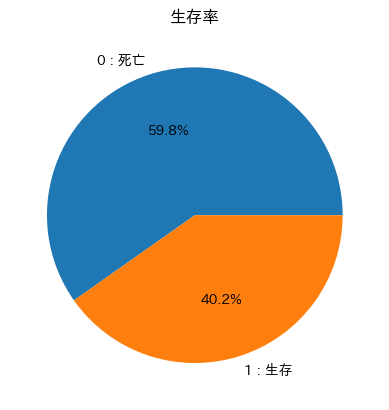

In [ ]:
# 生存率を可視化
fig, ax = plt.subplots()
labels = ["0 : 死亡","1 : 生存"]
ax.pie(train['survived'].value_counts(), labels=labels ,autopct="%.1f%%")
ax.set_title('生存率')
plt.show()

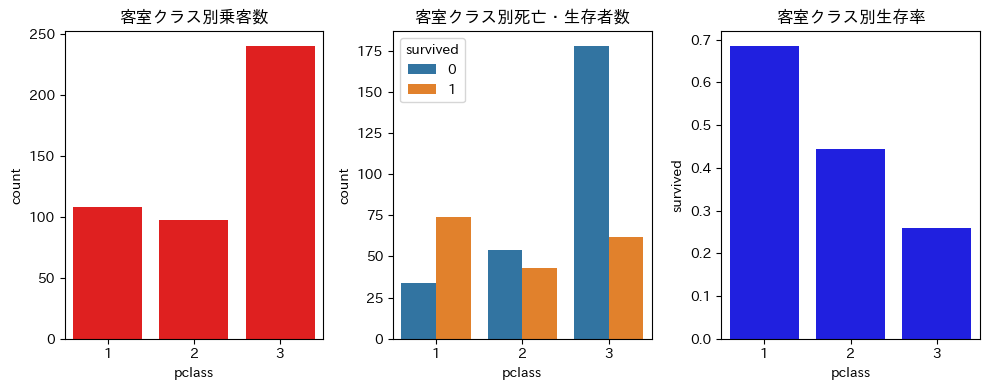

In [ ]:
# 客室クラス別の人数と生存率を可視化
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='pclass', data=train, color='r', ax=ax[0])
sns.countplot(x='pclass', hue='survived', data=train, ax=ax[1])
sns.barplot(x='pclass', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('客室クラス別乗客数')
ax[1].set_title('客室クラス別死亡・生存者数')
ax[2].set_title('客室クラス別生存率')
plt.show()

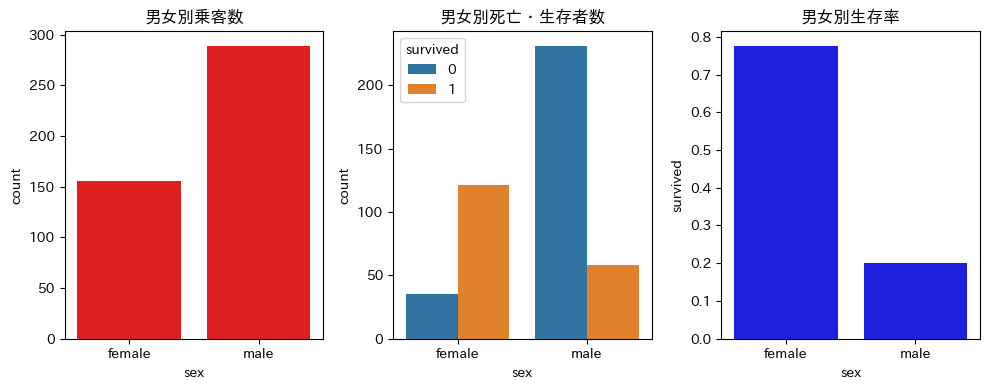

In [ ]:
# 男女別の人数と生存率を可視化
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='sex', data=train, color='r', ax=ax[0])
sns.countplot(x='sex', hue='survived', data=train, ax=ax[1])
sns.barplot(x='sex', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('男女別乗客数')
ax[1].set_title('男女別死亡・生存者数')
ax[2].set_title('男女別生存率')
plt.show()

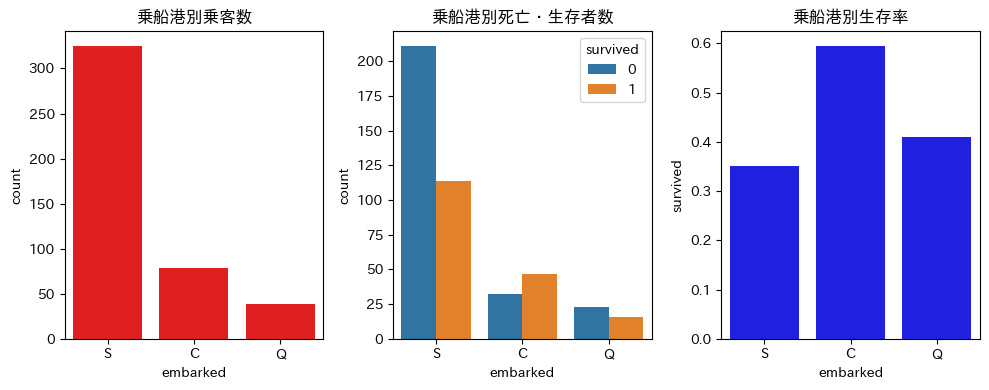

In [ ]:
# 乗船港別の人数と生存率を可視化
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='embarked', data=train, color='r', ax=ax[0])
sns.countplot(x='embarked', hue='survived', data=train, ax=ax[1])
sns.barplot(x='embarked', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('乗船港別乗客数')
ax[1].set_title('乗船港別死亡・生存者数')
ax[2].set_title('乗船港別生存率')
plt.show()

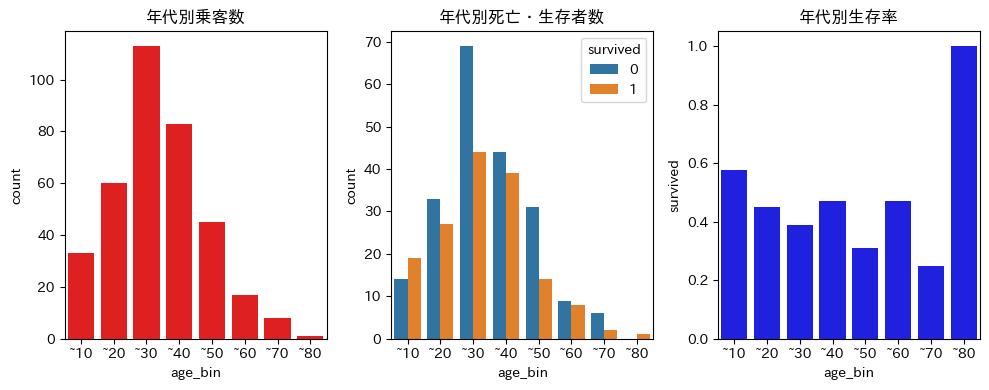

In [ ]:
# 年代別の人数と生存率を可視化
# 10歳毎の年代に分割
bins=list(range(0,81,10))
labels=['~'+str(x) for x in range(10, 81, 10)]
train['age_bin'] = pd.cut(train['age'], bins=bins, labels=labels)

fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='age_bin', data=train, color='r', ax=ax[0])
sns.countplot(x='age_bin', hue='survived', data=train, ax=ax[1])
sns.barplot(x='age_bin', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('年代別乗客数')
ax[1].set_title('年代別死亡・生存者数')
ax[2].set_title('年代別生存率')
train = train.drop('age_bin', axis=1)
plt.show()


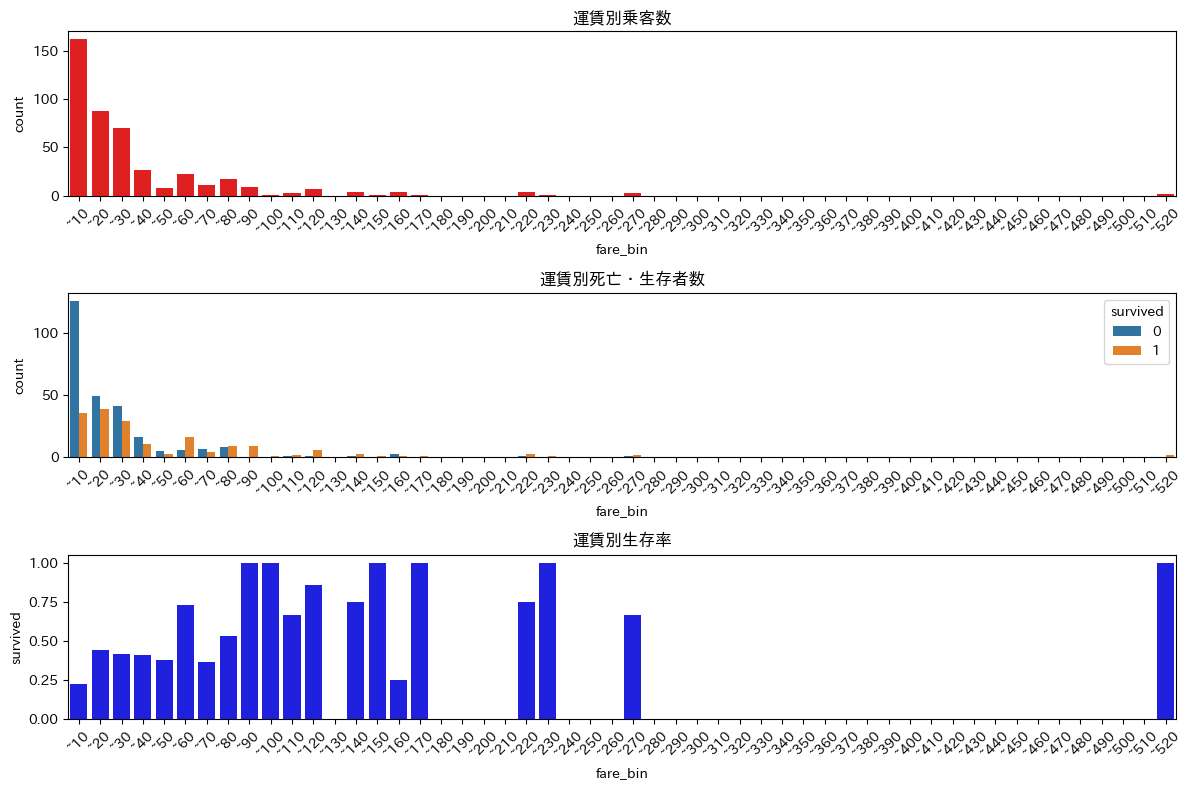

In [ ]:
# 運賃別の人数と生存率を可視化
# 10きざみの運賃に分割
bins=list(range(0,521,10))
bins[0]=-1
labels=['~'+str(x) for x in range(10, 521, 10)]
train['fare_bin'] = pd.cut(train['fare'], bins=bins, labels=labels)

fig, ax = plt.subplots(nrows=3, figsize=(12,8), tight_layout=True)
sns.countplot(x='fare_bin', data=train, color='r', ax=ax[0])
sns.countplot(x='fare_bin', hue='survived', data=train, ax=ax[1])
sns.barplot(x='fare_bin', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('運賃別乗客数')
ax[1].set_title('運賃別死亡・生存者数')
ax[2].set_title('運賃別生存率')
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)
plt.setp(ax[2].get_xticklabels(), rotation=45)
train = train.drop('fare_bin', axis=1)
plt.show()

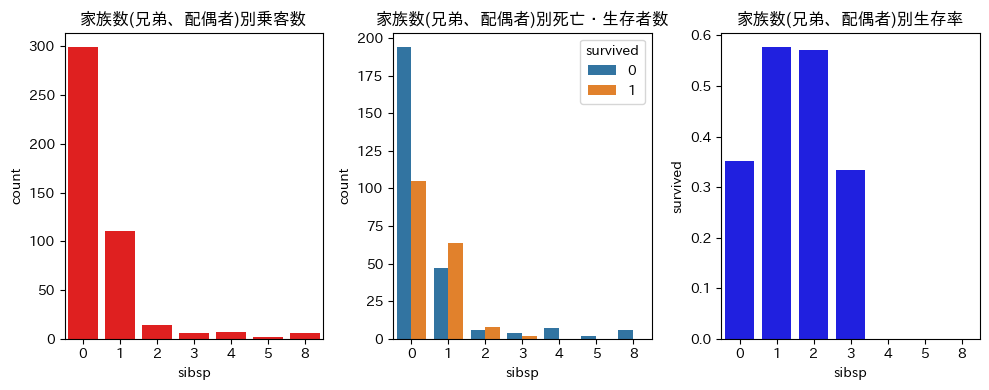

In [ ]:
# 家族数(兄弟、配偶者)別の人数と生存率を可視化
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='sibsp', data=train, color='r', ax=ax[0])
sns.countplot(x='sibsp', hue='survived', data=train, ax=ax[1])
sns.barplot(x='sibsp', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('家族数(兄弟、配偶者)別乗客数')
ax[1].set_title('家族数(兄弟、配偶者)別死亡・生存者数')
ax[2].set_title('家族数(兄弟、配偶者)別生存率')
plt.show()

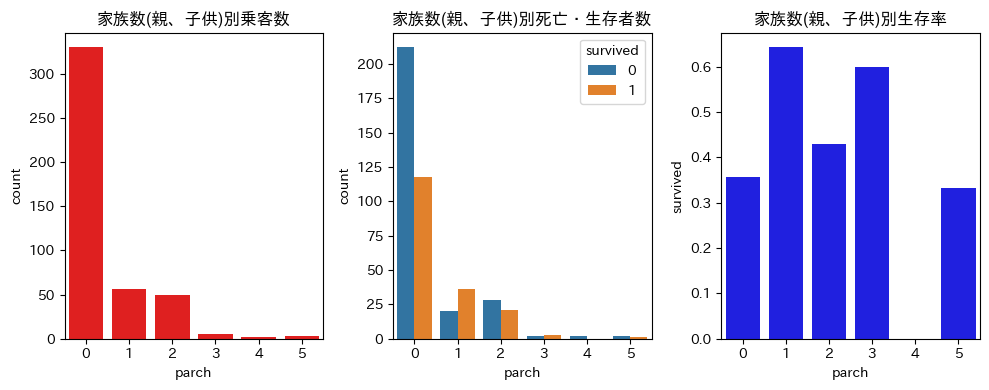

In [ ]:
# 家族数(親、子供)別の人数と生存率を可視化
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='parch', data=train, color='r', ax=ax[0])
sns.countplot(x='parch', hue='survived', data=train, ax=ax[1])
sns.barplot(x='parch', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('家族数(親、子供)別乗客数')
ax[1].set_title('家族数(親、子供)別死亡・生存者数')
ax[2].set_title('家族数(親、子供)別生存率')
plt.show()

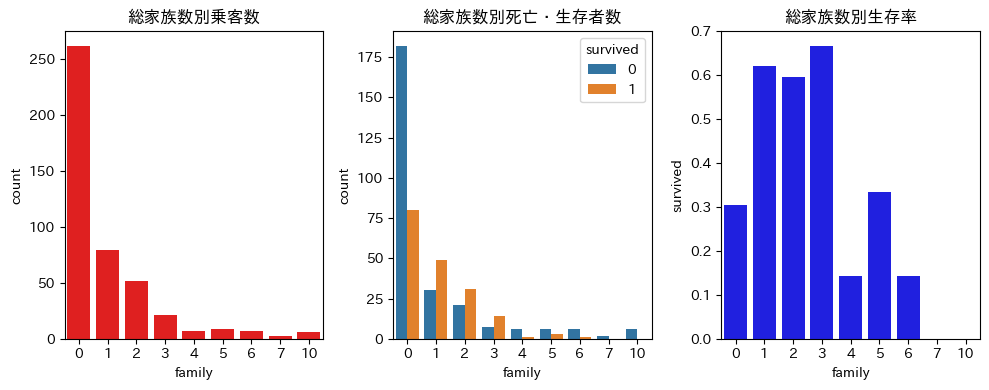

In [ ]:
# 総家族数別の人数と生存率を可視化
train['family'] = train['sibsp'] + train['parch']
fig, ax = plt.subplots(ncols=3, figsize=(10,4), tight_layout=True)
sns.countplot(x='family', data=train, color='r', ax=ax[0])
sns.countplot(x='family', hue='survived', data=train, ax=ax[1])
sns.barplot(x='family', y='survived', data=train, ci=None, color='b', ax=ax[2])
ax[0].set_title('総家族数別乗客数')
ax[1].set_title('総家族数別死亡・生存者数')
ax[2].set_title('総家族数別生存率')
train = train.drop('family', axis=1)
plt.show()

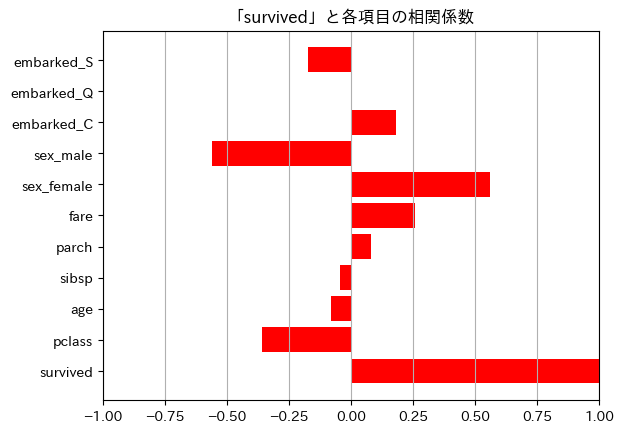

In [ ]:
# survivedと各項目の相関係数を可視化
corr = pd.get_dummies(train).corrwith(train["survived"])

fig, ax = plt.subplots()
ax.barh(corr.index, corr, color='r')
ax.set_title('「survived」と各項目の相関係数')
ax.set_xlim(-1, 1)
ax.grid(axis='x')

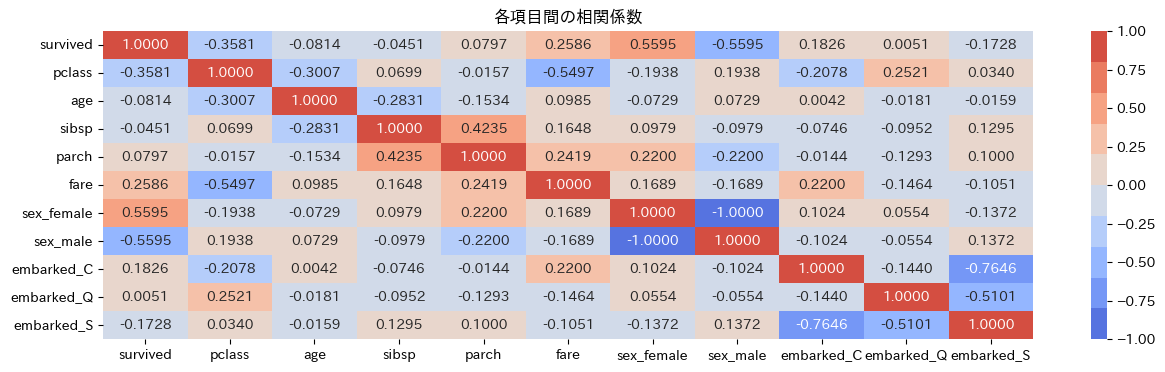

In [ ]:
# 各項目間の相関係数をヒートマップで可視化
corr = pd.get_dummies(train).corr()

fig, ax = plt.subplots(figsize=(15,4))
sns.heatmap(corr, cmap= sns.color_palette('coolwarm', 10), annot=True, fmt='.4f', vmin = -1, vmax = 1, ax=ax)
ax.set_title('各項目間の相関係数')
plt.show()

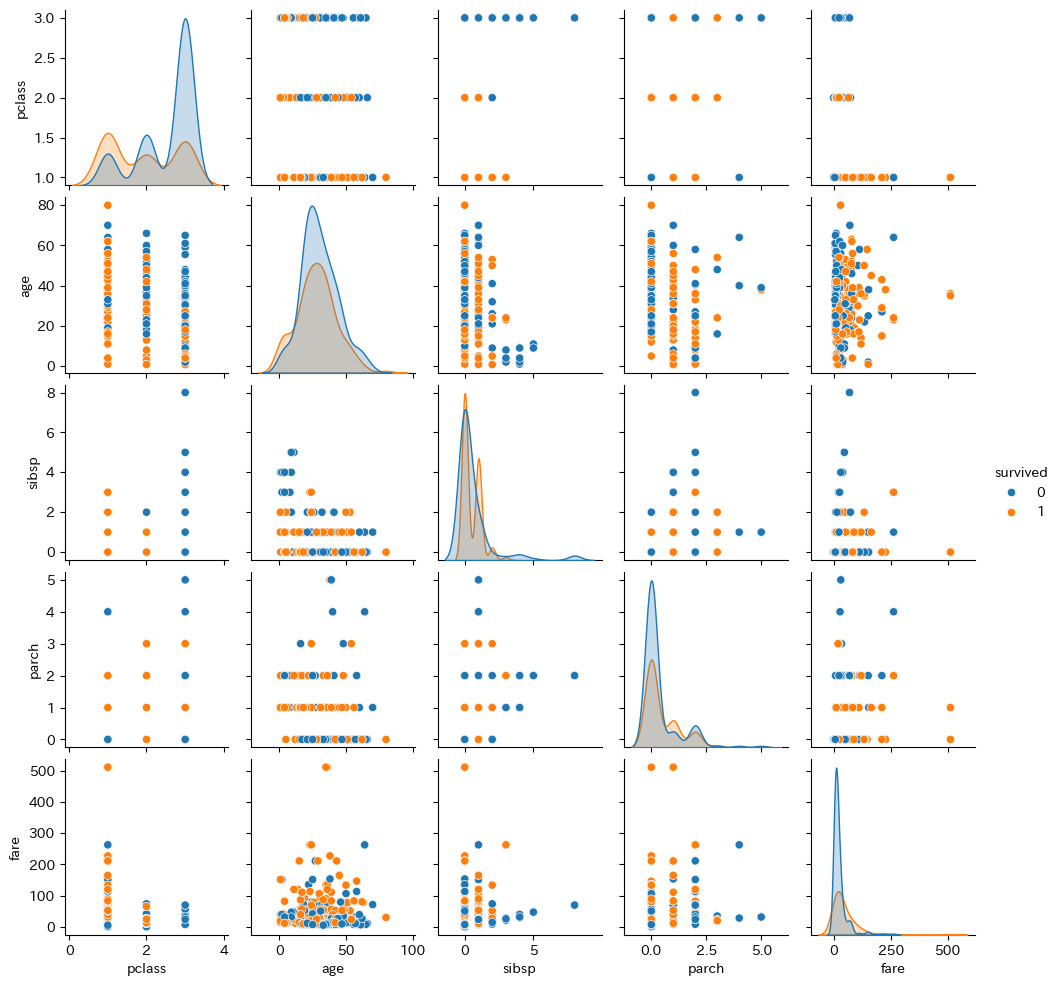

In [ ]:
# 散布図行列を表示
sns.pairplot(data=train, hue="survived", dropna=True, size=2)

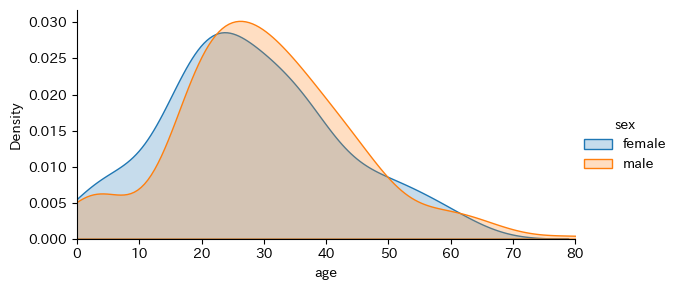

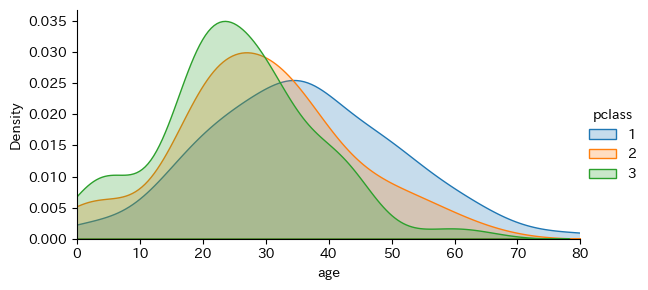

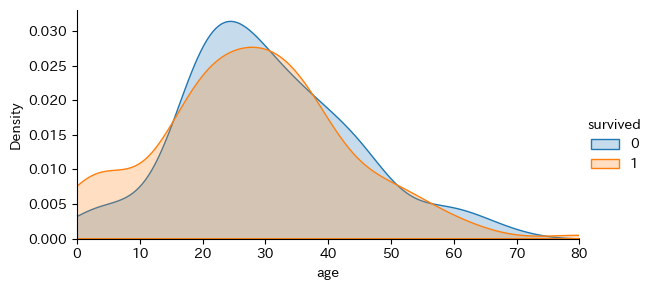

In [ ]:
# 年齢を男女別、客室クラス別、生存有無で層別化したカーネル密度推定グラフを可視化
oldest = train['age'].max()

facet1 = sns.FacetGrid(train, hue="sex", aspect=2)
facet1.map(sns.kdeplot, 'age', shade= True)
facet1.set(xlim=(0, oldest))
facet1.add_legend()

facet2 = sns.FacetGrid(train, hue="pclass",aspect=2)
facet2.map(sns.kdeplot,'age',shade= True)
facet2.set(xlim=(0, oldest))
facet2.add_legend()

facet3 = sns.FacetGrid(train, hue="survived",aspect=2)
facet3.map(sns.kdeplot,'age',shade= True)
facet3.set(xlim=(0, oldest))
facet3.add_legend()

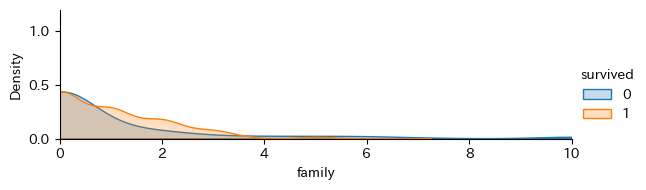

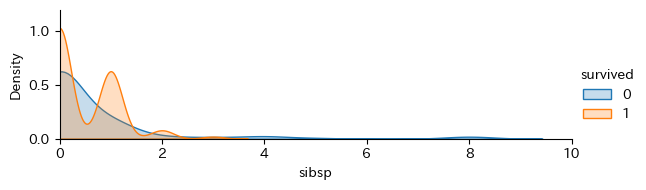

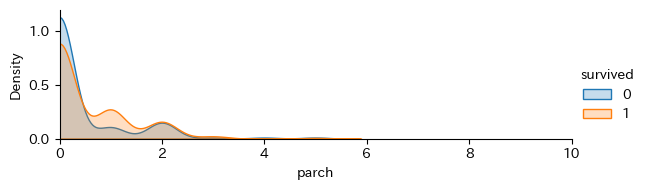

In [ ]:
# 家族人数を生存有無で層別化したカーネル密度推定グラフを可視化
train['family'] = train['sibsp'] + train['parch']

facet1 = sns.FacetGrid(train, hue="survived",height=2, aspect=3, ylim=(0, 1.2))
facet1.map(sns.kdeplot,'family',shade= True)
facet1.set(xlim=(0, train['family'].max()))
facet1.add_legend()

facet1 = sns.FacetGrid(train, hue="survived",height=2, aspect=3, ylim=(0, 1.2))
facet1.map(sns.kdeplot,'sibsp',shade= True)
facet1.set(xlim=(0, train['family'].max()))
facet1.add_legend()

facet2 = sns.FacetGrid(train, hue="survived",height=2, aspect=3, ylim=(0, 1.2))
facet2.map(sns.kdeplot,'parch',shade= True)
facet2.set(xlim=(0, train['family'].max()))
facet2.add_legend()

**4. データの前処理をしてみよう**

In [ ]:
# 学習用データと検証用データを結合（一括で前処理を行うため）
data = pd.concat([train, test])

In [ ]:
# embarkedの欠損値処理を実行
data['embarked'] = data['embarked'].fillna(data['embarked'].mode())

In [ ]:
# sibspとparchを統合し新しい特徴量（family）を作成
data['family'] = data['sibsp'] + data['parch']
data = data.drop(['sibsp', 'parch'], axis=1)

In [ ]:
# カテゴリー値（sex、embarked）をダミー変数で数値化
data = pd.get_dummies(data)

In [ ]:
# 欠損値補完前のデータを確認
data.head(20)

,survived,pclass,age,fare,family,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
id,,,,,,,,,,
3,1.0,1,35.0,53.1000,1,1,0,0,0,1
4,0.0,3,35.0,8.0500,0,0,1,0,0,1
7,0.0,3,2.0,21.0750,4,0,1,0,0,1
9,1.0,2,14.0,30.0708,1,1,0,1,0,0
11,1.0,1,58.0,26.5500,0,1,0,0,0,1
13,0.0,3,39.0,31.2750,6,0,1,0,0,1
16,0.0,3,2.0,29.1250,5,0,1,0,1,0
19,1.0,3,NaN,7.2250,0,1,0,1,0,0
23,1.0,1,28.0,35.5000,0,0,1,0,0,1


In [ ]:
# ageの欠損値をランダムフォレストで予測した結果で補完
from sklearn.ensemble import RandomForestRegressor

# 予測に使用する項目でデータフレームを作成
age_data = data.drop('survived', axis=1)

# 学習データ（欠損なし）とテストデータ（欠損あり）に分割
train_age = age_data[age_data['age'].notnull()]
test_age = age_data[age_data['age'].isnull()].drop('age', axis=1)

# 学習用データを目的変数と説明変数に分割
y = train_age['age']
X = train_age.drop('age', axis=1)

# ランダムフォレストで予測モデルを作成
clf = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
clf.fit(X, y)

# テストデータのageを予測
pred = clf.predict(test_age)
pred

# 欠損値を補完
data.loc[test_age.index, 'age'] = pred

In [ ]:
# 欠損値補完後のデータを確認
data.head(20)

,survived,pclass,age,fare,family,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
id,,,,,,,,,,
3,1.0,1,35.000000,53.1000,1,1,0,0,0,1
4,0.0,3,35.000000,8.0500,0,0,1,0,0,1
7,0.0,3,2.000000,21.0750,4,0,1,0,0,1
9,1.0,2,14.000000,30.0708,1,1,0,1,0,0
11,1.0,1,58.000000,26.5500,0,1,0,0,0,1
13,0.0,3,39.000000,31.2750,6,0,1,0,0,1
16,0.0,3,2.000000,29.1250,5,0,1,0,1,0
19,1.0,3,15.762250,7.2250,0,1,0,1,0,0
23,1.0,1,28.000000,35.5000,0,0,1,0,0,1


In [ ]:
# 結合したデータを学習用データと検証用データに分割
train = data.loc[train.index]
test = data.loc[test.index]
test = test.drop(["survived"], axis=1)

In [ ]:
# 学習用データを目的変数と説明変数に分割
y = train["survived"]                 # 目的変数
X = train.drop(['survived'], axis=1)  # 目的変数を除いたデータ

**5. モデリングをしてみよう**

In [ ]:
# 学習用データをモデル訓練用とモデル検証用に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# グリッドサーチで最良のパラメータの組み合わせを取得
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# パラメータ候補を辞書型で設定
param = {'max_depth':[2, 3, 4],                                             # デフォルト値：3
         'learning_rate':[0.024, 0.025, 0.026, 0.027],                      # デフォルト値：0.1
         'n_estimators':[103, 104, 105, 106, 107, 108, 109, 110, 111],      # デフォルト値：100
         'random_state':[0]}

# 勾配ブースティングによる学習
cv = 5
clf = GridSearchCV(GradientBoostingClassifier(), param, cv=cv)
clf.fit(X_train,y_train)

# 結果の確認
print('最良条件:\n', clf.best_estimator_)
print('最良スコア:\n',clf.best_score_)

最良条件:
 GradientBoostingClassifier(learning_rate=0.026, n_estimators=104,
                           random_state=0)
最良スコア:
 0.8286384976525822


In [ ]:
# 最良パラメータの勾配ブースティングでモデリング
model = GradientBoostingClassifier(learning_rate=0.026,
                                   n_estimators=104,
                                   random_state=0)
model.fit(X_train, y_train)
print("訓練データによる評価: ",model.score(X_train, y_train))
print("検証データによる評価: ",model.score(X_test, y_test))

訓練データによる評価:  0.8792134831460674
検証データによる評価:  0.7752808988764045


In [ ]:
# 評価用データの生存率を予測
pred = model.predict_proba(test)[:, 1]

In [ ]:
model.predict_proba(test)

**6. 予測結果を投稿しよう**

In [ ]:
# 応募用サンプルファイルに生存率をセットして出力
sample_submit[1] = pred
sample_submit.to_csv('submit_0128_1.tsv', header=None, sep='\t')

**お疲れ様でした！**